In [ ]:
!pip install -U transformers
!pip install google-genai

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
# Create a directory in Drive for Hugging Face cache
HF_CACHE_DIR = "/content/drive/MyDrive/hf_cache"
os.makedirs(HF_CACHE_DIR, exist_ok=True)

# Set environment variable so Hugging Face uses this cache
os.environ["TRANSFORMERS_CACHE"] = HF_CACHE_DIR

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/dataliteracy25/notebooks

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

## Preprocessing XML file to dataframe

In [ ]:
# NOTE: this was chatgpt generated and contains a small bug that the first paragraph is sometimes accidentally skipped => should be debugged!

import xml.etree.ElementTree as ET

def parse_contributions(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    contributions = []

    for intervention in root.findall(".//INTERVENTION"):
        orateur = intervention.find("ORATEUR")
        if orateur is None:
            continue

        # Speaker name (first and last name)
        name = orateur.attrib.get("LIB", "").replace("|", " ").strip()

        # Political group (if available)
        group = orateur.attrib.get("PP", "").strip()

         # Combine all paragraph texts
        para_texts = []
        for i, para in enumerate(intervention.findall("PARA")):
            # Turn paragraph XML into text
            text_parts = []
            skip_first_emphas = False

            # If this is the first paragraph, check if it starts with an <EMPHAS NAME="I">...</EMPHAS>
            if i == 0:
                first_child = next(iter(para), None)
                if (
                    first_child is not None
                    and first_child.tag == "EMPHAS"
                    and first_child.attrib.get("NAME") == "I"
                ):
                    # This is likely something like "for ID-Gruppen" → skip it
                    skip_first_emphas = True

            for child in para.iter():
                if child.tag == "EMPHAS" and skip_first_emphas:
                    skip_first_emphas = False
                    print("skipped emph", child.text)
                    continue  # skip the first <EMPHAS NAME="I">...</EMPHAS>
                if child.text:
                  text_parts.append(child.text)

            # Combine text and clean up
            text = "".join(text_parts).strip()
            if text:
                para_texts.append(text)

        speech = "\n".join(para_texts)

        contributions.append({
            "name": name,
            "group": group,
            "speech": speech
        })

    return contributions

In [ ]:
from google import genai
import os

try:
  client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
except KeyError:
  raise ValueError(f"Gemini API key not specified!")

def ask_gemini(prompt, model="gemini-2.5-flash"):
  resp = client.models.generate_content(
      model=model,
      contents=prompt,
  )
  return resp.text


def translate(speech):
  return ask_gemini(f"Translate this text to English. If it is already in English, just return the text verbatim.\n{speech}")

def summarize(speech):
  return ask_gemini(f"Summarize this text.\n{speech}")


In [ ]:
import os
def preprocess_xml(in_path, out_path, reprocess=False, use_gemini=False):
    if os.path.exists(out_path) and not reprocess:
        raise ValueError("Dataframe already exists. Do overwrite, change reprocess to True.")
    contributions = parse_contributions(in_path)
    # filter contributions without party membership
    contributions = [c for c in contributions if not c["group"] == 'NULL']
    if use_gemini:
        for c in tqdm(contributions, desc="Preprocessing speeches with Gemini"):
            c["summary"] = summarize(c["speech"])
            c["translation"] = translate(c["speech"])
    df = pd.DataFrame(contributions)
    df.to_csv(out_path)
    return df

In [ ]:
preprocess_xml("../data/CRE-9-2021-11-23-ITM-010_EN.xml", "../data/test_df.csv", reprocess=True, use_gemini=True)

skipped emph rapporteur
skipped emph Vice—President of the Commission
skipped emph im Namen der PPE-Fraktion
skipped emph f'isem il-grupp S&D
skipped emph au nom du groupe Renew
skipped emph för Verts/ALE-gruppen
skipped emph for ID-Gruppen
skipped emph on behalf of the ECR Group
skipped emph on behalf of The Left Group
skipped emph Vice-President of the Commission
skipped emph par écrit
skipped emph na piśmie
skipped emph schriftlich


Preprocessing speeches with Gemini: 100%|██████████| 19/19 [05:35<00:00, 17.63s/it]


,name,group,speech,summary,translation
0,Lena Düpont,PPE,".\nDenn richtig gemacht, kann gut gesteuerte l...",This text argues that well-managed legal migra...,"Because, when done right, well-managed legal m..."
1,Cyrus Engerer,S-D,.\nFlimkien man-negozjaturi tal-gruppi politiċ...,"The text advocates for a stronger, more ambiti...",Together with the negotiators of all political...
2,Fabienne Keller,Renew,".\nEn effet, certains secteurs clés de notre é...",This text highlights the significant labor nee...,"Indeed, some key sectors of our economy have a..."
3,Alice Kuhnke,Verts/ALE,".\nBristen på lagliga vägar, särskilt för migr...",The text highlights that the lack of legal pat...,"The lack of legal pathways, especially for mig..."
4,Peter Kofod,ID,".\nJeg må sige, jeg er godt nok chokeret. Komm...","Teksten udtrykker chok og utilfredshed, især r...","I must say, I am quite shocked. The commission..."
5,Charlie Weimers,ECR,.\nConsidering that this report concerns low— ...,This speaker criticizes an EU report on low- a...,Considering that this report concerns low— and...
6,Pernando Barrena Arza,The Left,".\nHowever, we believe it’s time to stop seein...",The text advocates for a broader understanding...,"However, we believe it’s time to stop seeing l..."
7,Balázs Hidvéghi,NI,– Tisztelt Elnök Úr! Képviselőtársaim! Az Euró...,The speaker strongly criticizes a recent Europ...,"Mr. President, my fellow Members of Parliament..."
8,Geoffroy Didier,PPE,"– Monsieur le Président, ceux qui font croire ...",The speaker argues against both the unrealisti...,"– Mr. President, those who promote the idea of..."
9,Sylvie Guillaume,S-D,"– Monsieur le Président, ouvrir des voies léga...","The speaker advocates for establishing legal, ...","– Mr. President, opening controlled and secure..."


## Feeding speeches to Speech Model

In [3]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v4", trust_remote_code=True, torch_dtype="auto").to("cuda")

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- configuration_jina_embeddings_v4.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, y

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

adapters/adapter_model.safetensors:   0%|          | 0.00/360M [00:00<?, ?B/s]

In [16]:
df = pd.read_csv("../data/test_df.csv")

In [20]:
def embedd_speech(key, out_path):
    embeddings = model.encode_text(texts=[c[key] for _, c in df.iterrows()], task="text-matching", prompt_name="query", return_numpy=True)
    np.save(out_path, embeddings)
    return embeddings

In [22]:
embeddings_speech = embedd_speech("speech", "../data/embeddings/test_df_speech.npy")
embeddings_translation = embedd_speech("translation", "../data/embeddings/test_df_translation.npy")
embeddings_summary = embedd_speech("summary", "../data/embeddings/test_df_summary.npy")

Encoding texts...: 100%|██████████| 3/3 [00:12<00:00,  4.03s/it]


## Clustering speech embeddings

In [ ]:
embeddings_speech = np.load("../data/embeddings/test_df_speech.npy")
embeddings_translation = np.load("../data/embeddings/test_df_translation.npy")
embeddings_summary = np.load("../data/embeddings/test_df_summary.npy")

In [28]:
# mappings generated by chatgpt
group_orientation_map = {
    "S&D": "centre-left / social democratic",
    "ID": "far-right / nationalist, populist",
    "PPE": "centre-right / conservative, Christian democratic",
    "ECR": "right-wing / conservative, eurosceptic",
    "Verts/ALE": "green / progressive, pro-European",
    "Renew": "centrist / liberal, pro-European",
    "The Left": "left-wing / socialist, anti-capitalist",
    "NI": "non-attached members (no unified ideology; varies individually)"
}

In [24]:
# color maps generated by chagpt
color_map = {
    "ID": "#00008B",        # dark blue – far-right
    "ECR": "#1E90FF",       # blue – right-wing conservative
    "PPE": "#4169E1",       # royal blue – centre-right
    "Renew": "#FFD700",     # golden yellow – centrist liberal
    "S-D": "#FF4500",       # orange-red – centre-left
    "Verts/ALE": "#32CD32", # green – progressive/green
    "The Left": "#FFFF00",  # bright yellow – left-wing
    "NI": "#808080"         # grey – non-inscrits (no unified ideology)
}

In [25]:
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_and_cluster(title, embeddings, texts):
  pca = PCA(n_components=2)
  reduced = pca.fit_transform(embeddings)

  # 2. KMeans clustering
  k = 5
  kmeans = KMeans(n_clusters=k, random_state=42)
  labels = kmeans.fit_predict(reduced)

  # 3. Plot
  plt.figure(figsize=(10, 8))

  scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=150)
  plt.title(title)

  # 4. Add text labels
  for i, txt in enumerate(texts):
      plt.text(reduced[i,0]+0.02, reduced[i,1]+0.02, txt, fontsize=12, color=color_map[txt])

  plt.legend(*scatter.legend_elements(), title="Cluster")
  plt.show()


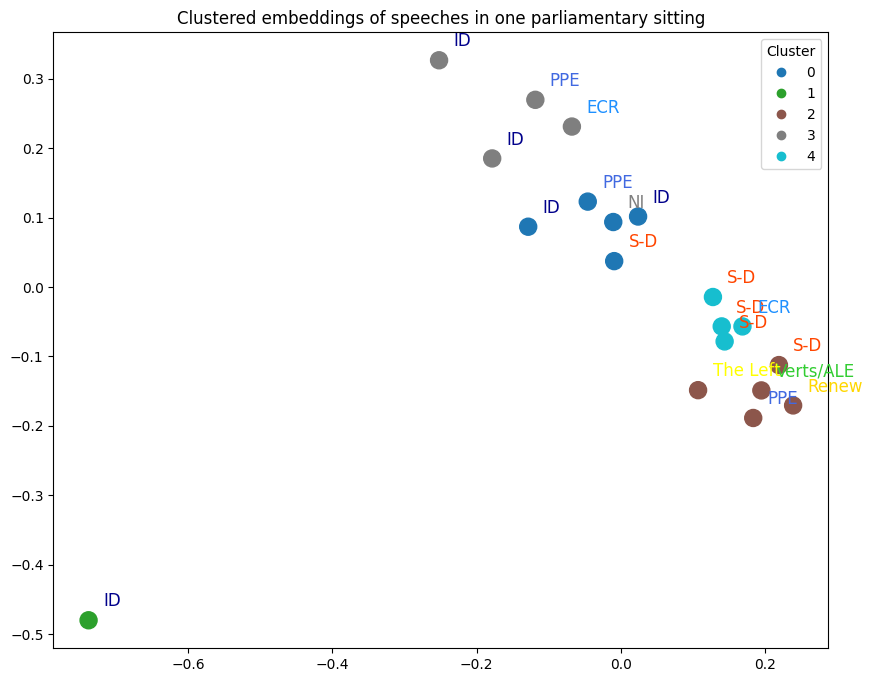

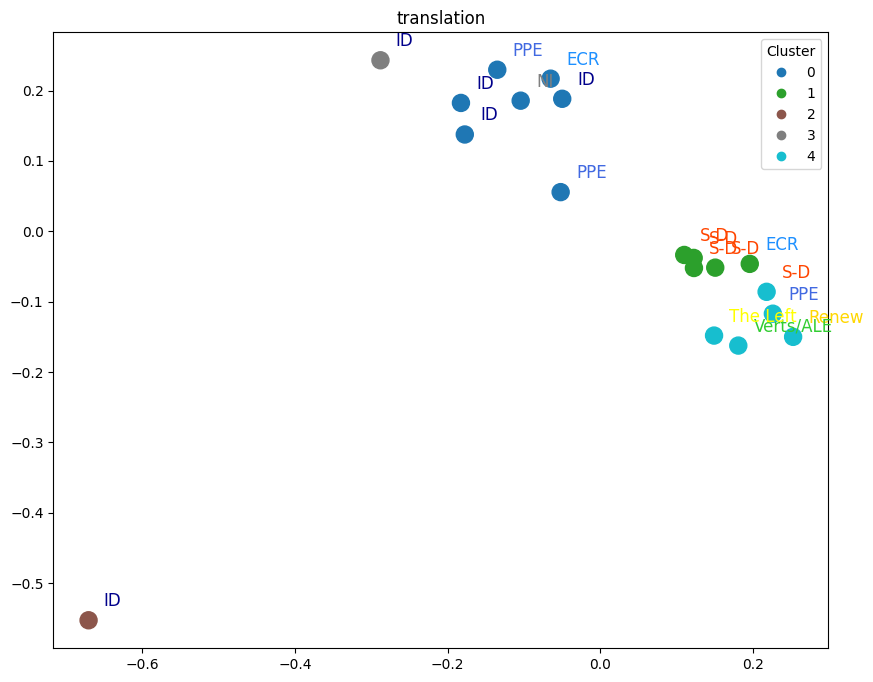

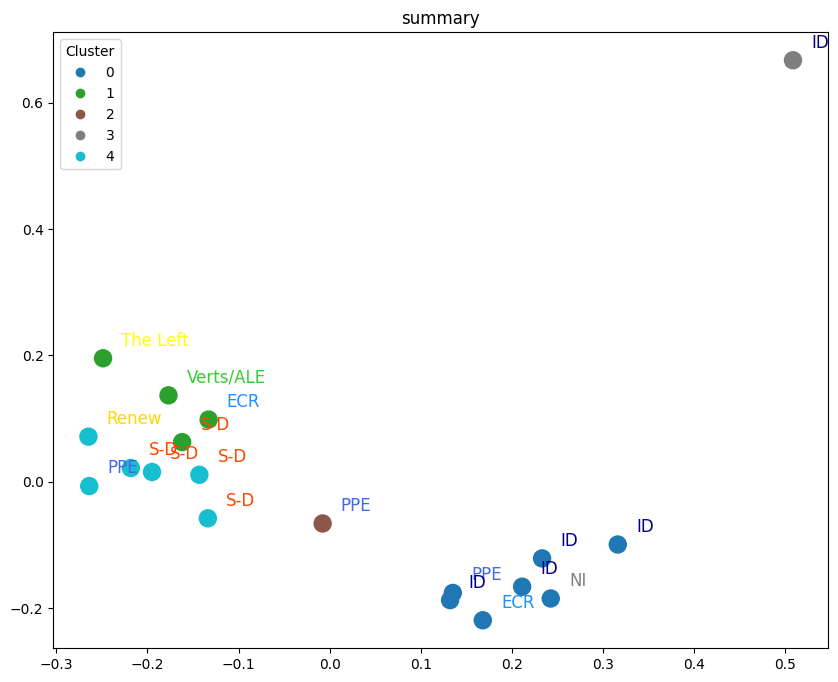

In [29]:
for embedding, name in zip([embeddings_speech, embeddings_translation, embeddings_summary], ["Clustered embeddings of speeches in one parliamentary sitting", "translation", "summary"]):
  plot_and_cluster(name, embedding,df["group"].values)

In [ ]:
! git commit -am "redid initial test"